In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(10,10)
mpl.rcParams['axes.grid']=False

import numpy as np
from  PIL import Image
import time
import functools
import cv2 as cv


%tensorflow_version 1.x
import tensorflow as tf


from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow 1.x selected.
Eager execution: True


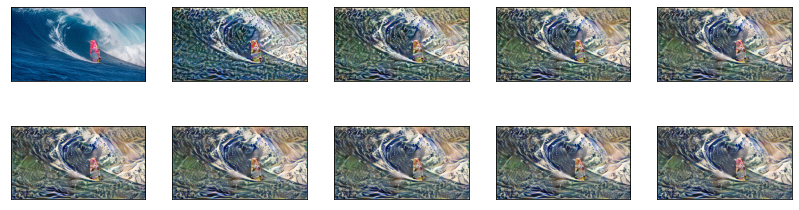

In [ ]:
content_path = "content.jpg"
style_path = "style.jpg"

# max_dim=512
# img=Image.open(content_path)
# long = max(img.size)
# scale = max_dim/long
# print(img.size)
# img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
# print(img.size)
# img = kp_image.img_to_array(img)

# img = np.expand_dims(img,axis=0)



def load_img(path_to_img):
    max_dim=512
    img=Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = kp_image.img_to_array(img)

    img = np.expand_dims(img,axis=0)
    return img

def imshow(img, title=None):
    out=np.squeeze(img, axis=0)
    out= out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

# plt.figure(figsize=(10,10))

# content=load_img(content_path).astype('uint8')
# style = load_img(style_path).astype('uint8')

# plt.subplot(1,2,1)
# imshow(content , 'Content Image')

# plt.subplot(1,2, 2)
# imshow(style, 'Style Image')
# plt.show()


def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img= tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x=processed_img.copy()
    if len(x.shape)==4:
        x = np.squeeze(x, axis=0)
    assert len(x.shape) == 3,("input must be of correct dimension")

    if len(x.shape) != 3:
        raise ValueError("Invalid inpu to deprocess image")

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x= x[:,:,::-1]

    x= np.clip(x, 0 , 255).astype('uint8')
    return x

content_layers= [
                 'block5_conv1']

style_layers = ['block1_conv1',
                #'block1_conv2',
               # 'block1_conv3',
                'block2_conv1',
              #  'block2_conv2',
               # 'block2_conv3',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',
             #   'block5_conv2',
              
                
                
               ]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top= False, weights='imagenet')
    vgg.trainable = False

    style_output = [vgg.get_layer(name).output for name in style_layers]
    content_output = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_output + content_output

    return models.Model(vgg.input , model_outputs)

def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1,channels])
    n=tf.shape(a)[0]
    gram = tf.matmul(a,a,transpose_a =True)
    return gram/ tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style-gram_target))

def get_feature_representations(model, content_path, style_path):

    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight= loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    weights_per_style_layer = 1.0/ float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weights_per_style_layer * get_style_loss(comb_style[0], target_style)

    weights_per_content_layer = 1.0/ float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weights_per_content_layer * get_content_loss(comb_content[0],target_content)

    style_score*= style_weight
    content_score *= content_weight

    loss= style_score+ content_score
    return loss, style_score,content_score

def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)

    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss



import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
    style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
  iter_count = 1
  
  best_loss, best_img = float('inf'), None
  
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


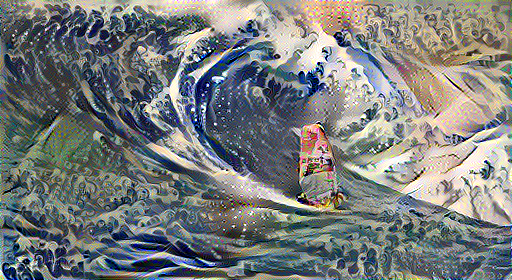

In [ ]:
Image.fromarray(best)

In [ ]:
model = get_model() 
for layer in model.layers:
  layer.trainable = False
style_features, content_features = get_feature_representations(model, content_path, style_path)


In [ ]:
images = tf.image.decode_jpeg(style_features, channels=3)

UnimplementedError: ignored

In [ ]:
content_image = load_and_process_img(content_path)
style_image = load_and_process_img(style_path)

style_outputs = model(style_image)
content_outputs = model(content_image)

style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

In [ ]:
tf.print(style_features)


[[[[0 16.2909908 19.5797405 ... 0 25.2030849 0]
  [0 30.4064674 70.172966 ... 0 185.698578 152.859863]
  [0 28.9715462 69.8116684 ... 0 184.508591 153.954956]
  ...
  [0 3.76398563 46.2367134 ... 0 150.678482 119.315041]
  [0 2.36647534 45.4194489 ... 0 151.148438 121.502464]
  [6.72672081 19.0133915 74.9346085 ... 0 228.384552 228.189758]]

 [[0 11.1038752 0 ... 0 0 0]
  [57.2278595 23.4872608 48.6197 ... 0 0 33.7343483]
  [61.7660446 20.5035877 46.332016 ... 0 0 31.531]
  ...
  [7.14874887 0 35.3303719 ... 0 11.5168295 44.3131104]
  [13.3458958 0 33.2883186 ... 0 10.8862047 44.9113846]
  [190.892502 21.1907749 83.5176 ... 0 173.029984 223.999741]]

 [[0 3.68362236 0 ... 0 0 0]
  [29.7669983 10.5177889 39.3684158 ... 0 0 33.2070312]
  [19.9423294 7.10860968 35.8364 ... 0 0 25.5330181]
  ...
  [13.8758793 1.80213904 39.7454796 ... 0 21.0546932 57.3517914]
  [12.5273685 0 34.5345078 ... 0 13.3651609 48.2375946]
  [189.011551 21.0929108 83.6920319 ... 0 172.722153 223.889084]]

 ...

 [[